### Segment Any change

In [1]:
from segment_any_change.main import BitemporalMatching, PointQueryMecanism
from segment_any_change.utils import load_levircd_sample, show_img, load_img
from segment_any_change.mask_items import ImgType, ListProposal

import numpy as np
from typing import Union
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cv2
from copy import deepcopy
from typing import Tuple, Any, Dict, List, Union 

/home/MDizier/miniforge3/envs/magic_pen/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
def flush_memory():
    import gc
    import torch
    gc.collect()
    torch.cuda.empty_cache()
flush_memory()

In [3]:
def show_pair_img(img_A:  Union[str, np.ndarray], img_B: Union[str, np.ndarray]):
    if isinstance(img_A, str):
        img_A = load_img(img_A)
    if isinstance(img_B, str):
        img_B = load_img(img_B)
    pair = np.hstack((img_A, img_B))
    show_img(pair)

In [4]:
def box_xywh_to_xyxy(bbox_xywh):
    
    box_xyxy = deepcopy(bbox_xywh)
    box_xyxy[2] =  box_xyxy[2] + box_xyxy[0]
    box_xyxy[3] =  box_xyxy[3] + box_xyxy[1]
    return box_xyxy
    
def sample_point_from_bbox(bbox: Tuple, center: bool=True) ->np.ndarray:

    bbox_xyxy = box_xywh_to_xyxy(bbox)

    if center:
        point = (
            (bbox_xyxy[0] + bbox_xyxy[2]) // 2,
            (bbox_xyxy[1] + bbox_xyxy[3]) // 2
        )
    else:
        offset_h = np.random.choice(bbox[3])
        offset_w = np.random.choice(bbox[2])
        point = (
            bbox_xyxy[0] + offset_h,
            bbox_xyxy[1] + offset_w
        )

    return np.array(point)

In [5]:
def show_sim_change_from_prompt(img: np.ndarray, input_prompt: np.ndarray, sim_items: ListProposal):
    def convert_bbox_plt(bbox):
        """Matplotib rectangle bbox format : xminymin,h,w"""
        return ((bbox[0], bbox[1]), *bbox[2:])
    show_img(img)
    ax = plt.gca()
    boxes = (
        [convert_bbox_plt(_.meta["bbox"])
         for _ in sim_items if isinstance(_.meta, dict)] # some bbox are not unique with vit_h
    )
    colors = plt.cm.rainbow(np.linspace(0, 1, len(boxes)))
    for bbox, c in zip(boxes, colors):
        # add rectangle to plot
        ax.add_patch(Rectangle(*bbox,
                     edgecolor=c,
                     fill=False,
                     lw=2))
    ax.scatter(*input_prompt.ravel(),
           color='green',
           marker='*',
           s=300,
           edgecolor='white',
           linewidth=0.8)

#### Import samples LEVIR-CD

In [6]:
pair_img = load_levircd_sample(1, seed=42)
path_label,path_A, path_B = pair_img.iloc[0]

In [7]:
img_A = load_img(path_A)
img_B = load_img(path_B)

### Run SegAnyChange

In [8]:
sam_params = {
    "points_per_side": 32,
    "points_per_batch": 64,
    "pred_iou_thresh": 0.88,
    "stability_score_thresh": 0.95,
    "stability_score_offset": 1.0,
    "box_nms_thresh": 0.7,
    "crop_n_layers": 0,
    "crop_nms_thresh": 0.7,
    "crop_overlap_ratio": 512 / 1500,
    "crop_n_points_downscale_factor": 1,
    "point_grids": None,
    "min_mask_region_area": 0,
    "output_mode": "binary_mask",
}
device="cuda"

In [9]:
filter_change_proposals = "otsu"

matcher = BitemporalMatching(model_type="vit_h", **sam_params)
items_change = matcher.run(
    img_A=load_img(path_A),
    img_B=load_img(path_B),
    filter_method=filter_change_proposals
)

2024-05-03 16:43:42,340 - INFO ::  Function generate Took 6.9037 seconds
2024-05-03 16:43:48,504 - INFO ::  Function generate Took 6.1593 seconds
/home/MDizier/projects/stage_stylo_magique_2024/src/segment_any_change/embedding.py:29: RuntimeWarning: Mean of empty slice
  mask_embedding = np.nanmean(img_embedding * mask[None, ...], axis=(1, 2))
/home/MDizier/projects/stage_stylo_magique_2024/src/segment_any_change/matching.py:16: RuntimeWarning: invalid value encountered in scalar divide
  return -(x1 @ x2) / (np.linalg.norm(x1) * np.linalg.norm(x2))
2024-05-03 16:43:55,425 - INFO ::  nan values ci 10
2024-05-03 16:43:55,426 - INFO ::  nan values ci1 11
2024-05-03 16:43:56,145 - INFO ::  Function run Took 20.7082 seconds


In [10]:
items_change,  mask_ci_binary, th = items_change

### Update 3-05 : pixel segmentation

* Masque global comme aggregat de l'ensemble des masques (somme, moyenne, etc). Thresholding appliqué à ce mask global puis filtre sur les masques

In [ ]:
TO DO : match with masks on IOU on binarized

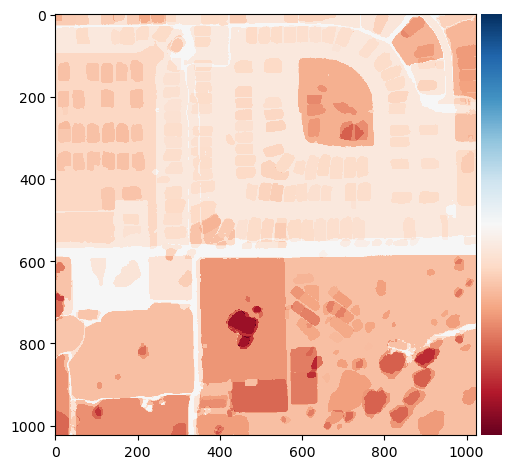

In [11]:
# agg func = sum
show_img(items_change.mask_ci)

Text(0.5, 1.0, 'Distribution of pixels values (sum aggregate)')

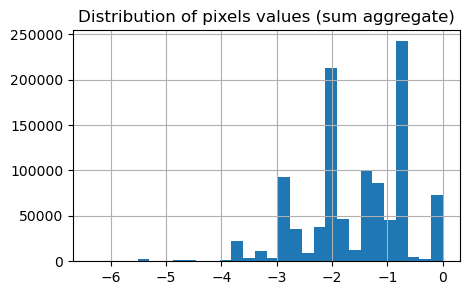

In [23]:
pd.Series(items_change.mask_ci.flatten()).hist(bins=30, figsize=(5,3))
plt.title("Distribution of pixels values (sum aggregate)")

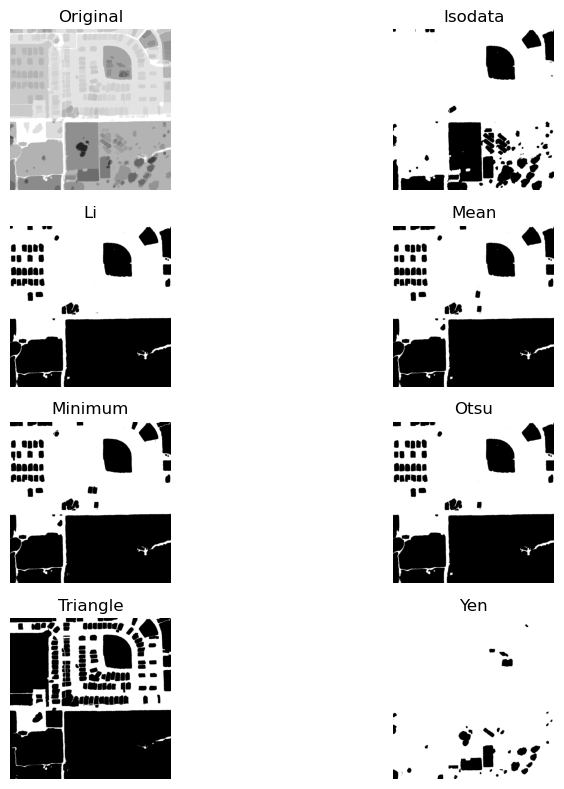

In [20]:
from skimage.filters import try_all_threshold
_ = try_all_threshold(items_change.mask_ci, figsize=(10, 8), verbose=False)

#### Quantile segmentation

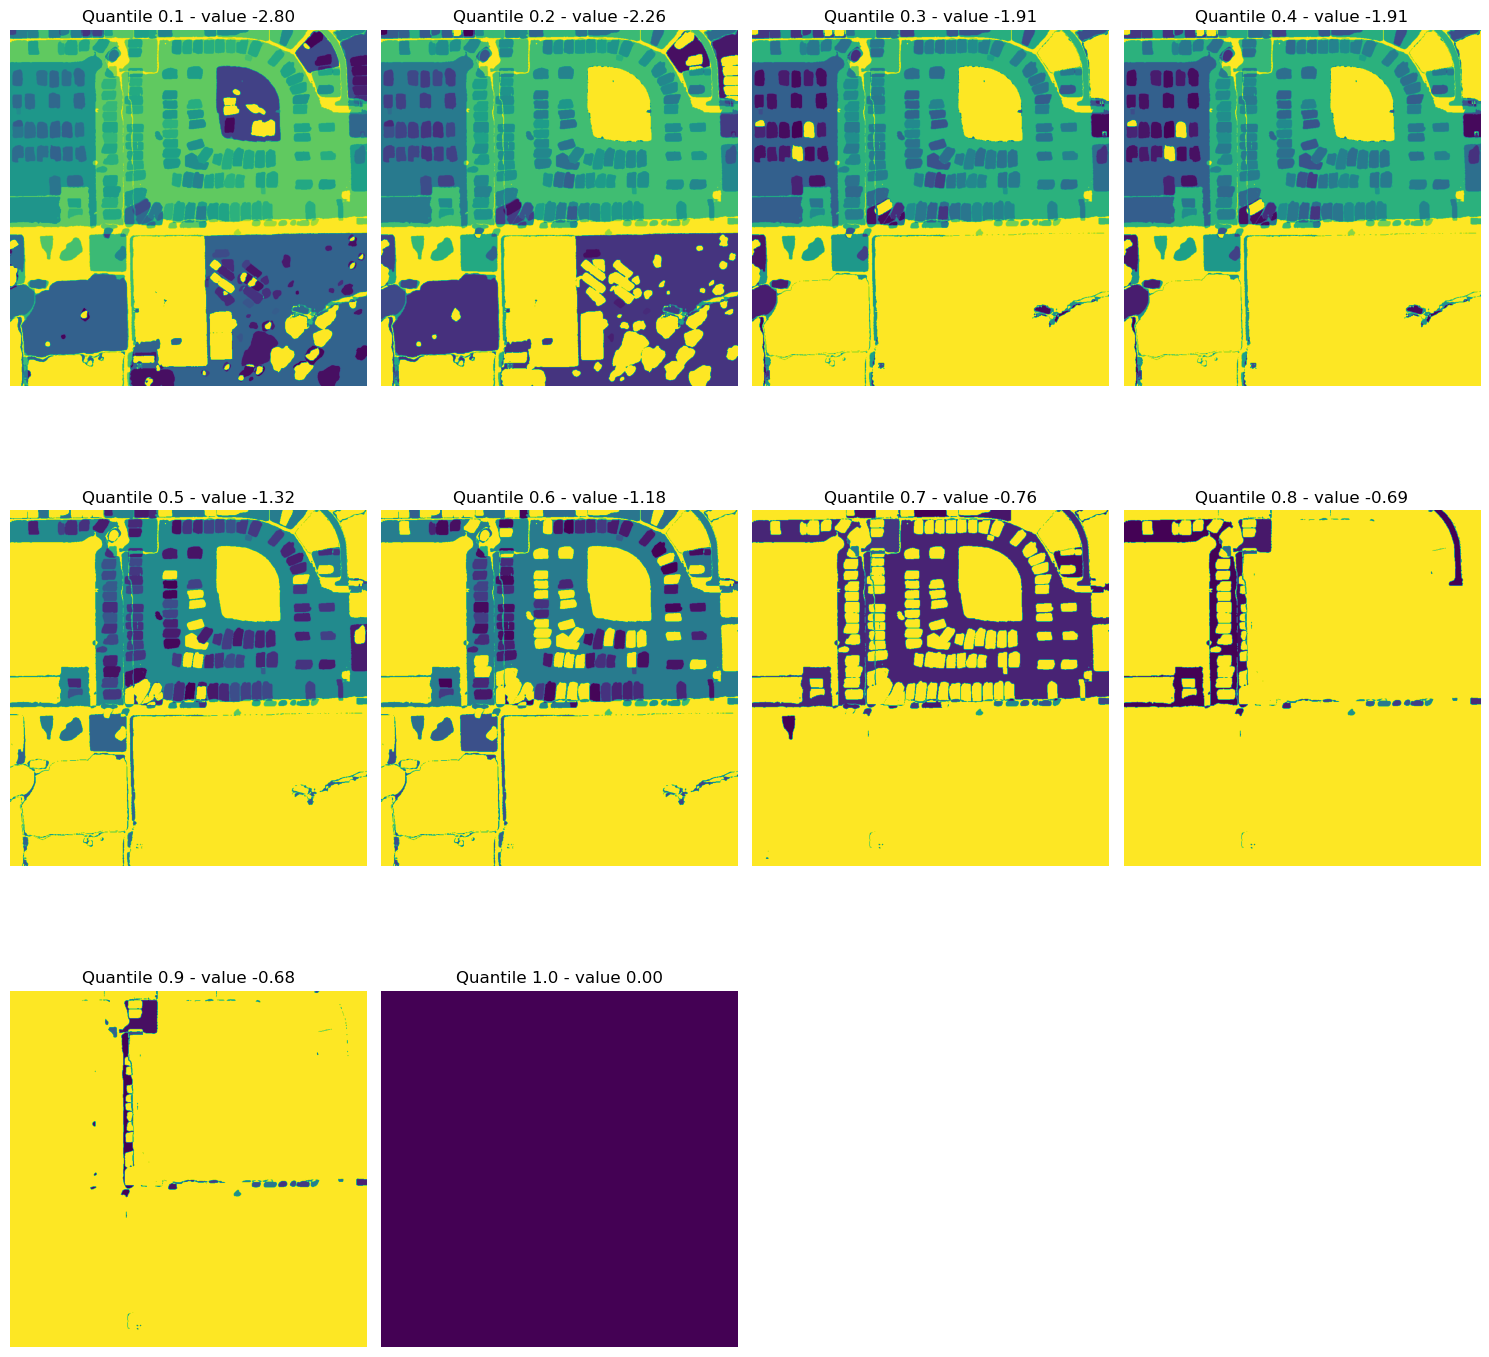

In [14]:
fig, axes = plt.subplots(3, 4, figsize=(15, 15))
axes = axes.ravel()

_ = [axes[_].set_visible(False) for _ in [10, 11]]

for i, q in enumerate(np.linspace(0.1, 1, 10)):
    mask_stack = np.zeros((1024, 1024))
    v = np.quantile((items_change.mask_ci), q)
    # lowest value => no change
    q_mask = ((items_change.mask_ci > v) * items_change.mask_ci)
    axes[i].imshow(q_mask, cmap="viridis")
    axes[i].set_axis_off()
    axes[i].set_title(f"Quantile {q:.1f} - value {v:.2f}")
    
plt.tight_layout()

* Il faut eliminer les gros objets qui "cachent les objets plus petits" (cf exemple aire en haut a gauche) qui n'etaient pas presents avec le proposal_matching => pourquoi ?

* **A VOIR** Thresholding based on quantile for **SegAnyChange** [cliquez ici](#seganychangeq) => meilleur

/home/MDizier/miniforge3/envs/magic_pen/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


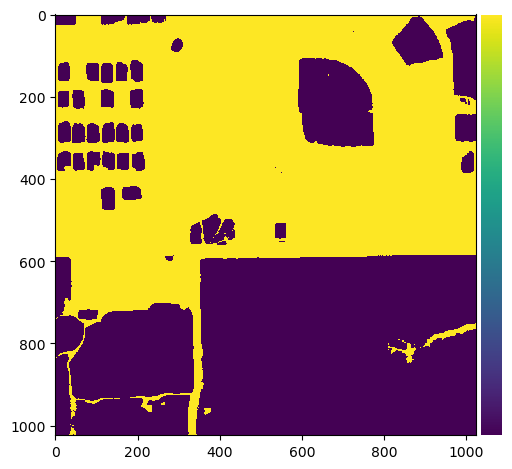

In [13]:
# example with otsu
show_img(mask_ci_binary)

#### Extract sample point from mask

In [ ]:
len(items_change)

In [ ]:
idx=45
sample_point = sample_point_from_bbox(items_change[idx].meta["bbox"])
input_points = np.expand_dims(sample_point, (0, 1))
input_labels = np.array([[1]])

In [14]:
items_change[72].meta["bbox"]

[615, 253, 29, 44]

In [15]:
input_points = np.array([[[286, 281]]])


#### Query Prompt Mecanism

In [16]:
filter_query_sim = 70
items_change_copy = deepcopy(items_change)

sim_obj_change = PointQueryMecanism(
                    predictor=matcher.mask_generator.predictor,
                    items_change=items_change_copy
                ).run(
                    points=input_points,
                    method_filtering=filter_query_sim,
                    image=None,
                    labels=input_labels
                )
print(len(sim_obj_change))

2024-05-03 14:23:42,453 - INFO ::  Function run Took 0.0210 seconds


154


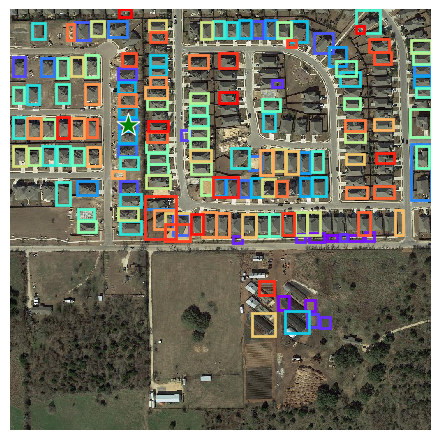

In [17]:
show_sim_change_from_prompt(img_B, input_points, sim_obj_change)

* Comparer avec l'ensemble des changements / ensemble des objets
* Faire varier le seuil de décision de similarité : 
  * evaluer sur ground truth  
  * quantifier evolution nombre de changements 
* Add interactive visualization
  * Plotly
  * convert to tiff => folium / leafmap

/home/MDizier/miniforge3/envs/magic_pen/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


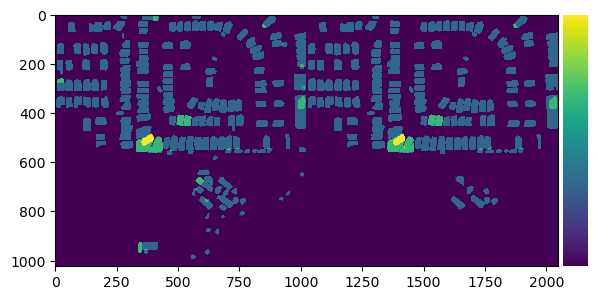

In [49]:
all_changes_mask = np.sum(np.stack([_.mask for _ in items_change]), axis=0)
sim_changes_mask = np.sum(np.stack([_.mask for _ in sim_obj_change]), axis=0)
show_pair_img(all_changes_mask, sim_changes_mask)

* Left : all changes (based on otsu th)
* Right : similar changes (based on th)

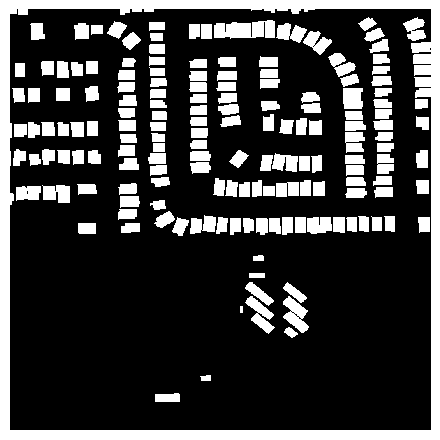

In [36]:
show_img(load_img(path_label))

In [37]:
query_sim_angle = [_.chgt_angle for _ in  sim_obj_change]

Text(0.5, 1.0, "Distribution des angles des vecteurs de changement par rapport à l'objet issu du prompt")

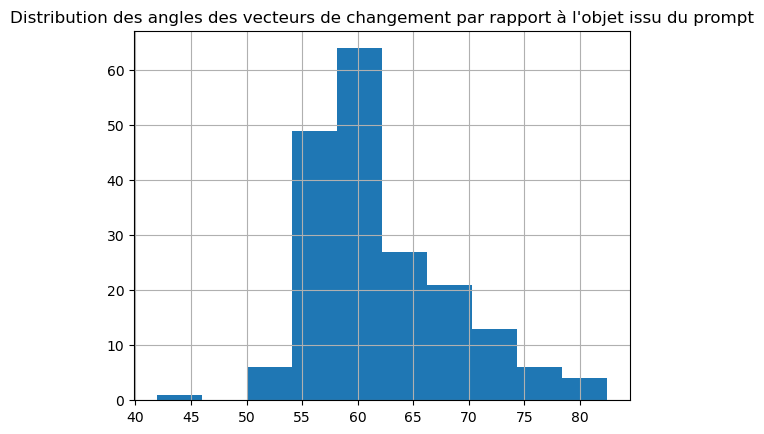

In [38]:
pd.Series(query_sim_angle).hist()
plt.title("Distribution des angles des vecteurs de changement par rapport à l'objet issu du prompt")

In [27]:
from kornia.geometry.transform import Resize
import torch
import torch.nn.functional as F

In [51]:
masks = np.stack([_.mask for _ in items_change])
cis = np.stack([_.confidence_score for _ in items_change])

In [52]:
masks = torch.as_tensor(
    masks, dtype=torch.float, device=device
            )

cis = torch.as_tensor(
    cis, dtype=torch.float, device=device
            )

In [53]:
cis.shape

torch.Size([191])

In [56]:
masks_ci = masks * cis[:,None, None]

In [64]:
torch.unique(masks_ci[34])

tensor([-0.5080, -0.0000], device='cuda:0')

In [65]:
cis[34]

tensor(-0.5080, device='cuda:0')

In [44]:
masks_ = F.interpolate(
    masks[:,None,...],
    (256, 256),
    mode="bilinear",
    align_corners=False,
)

In [45]:
masks_2 = Resize((256, 256))(masks)

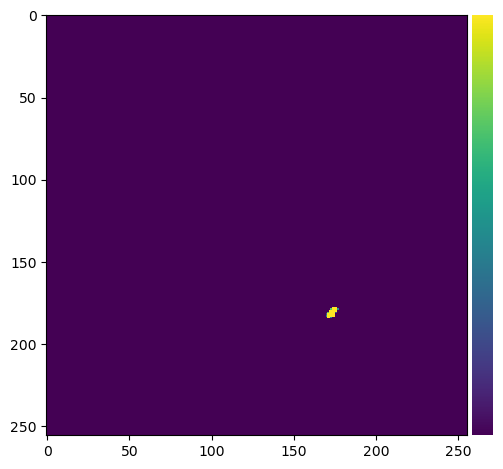

In [49]:
show_img(masks_2.detach().cpu().numpy()[12])

In [46]:
masks_2.shape

torch.Size([191, 256, 256])

In [42]:
masks_.shape

torch.Size([191, 1, 256, 256])

In [19]:
masks.shape

(191, 1024, 1024)

In [72]:
def resize2d(arr: np.ndarray, target_size:Tuple, method: int):
    return cv2.resize(src=arr, dsize=target_size, interpolation=method)


In [74]:
resize2d(masks, target_size=(masks.shape[0], 1024, 2014), method=cv2.INTER_CUBIC)

error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - Can't parse 'dsize'. Expected sequence length 2, got 3
>  - Can't parse 'dsize'. Expected sequence length 2, got 3


In [67]:
from segment_any_change.mask_items import ItemProposal

In [68]:
A = ItemProposal(
    mask=1,
    embedding=1,
    confidence_score=1,
    meta=1,
)

B = ItemProposal(
    mask=1,
    embedding=1,
    confidence_score=1,
    meta=1,
)

In [69]:
A.id, B.id

(403, 404)

#### Multi bbox associated to one mask

* Side effect with vit_h
* wtf

In [9]:
items_change[0].meta

{'area': 680,
 'bbox': [398, 0, 24, 27],
 'predicted_iou': 0.9544848203659058,
 'point_coords': [[400.0, 16.0]],
 'stability_score': 0.9883551597595215,
 'crop_box': [0, 0, 1024, 1024]}

In [10]:
items_change[4].meta

[{'area': 1662,
  'bbox': [356, 0, 65, 27],
  'predicted_iou': 0.9412738084793091,
  'point_coords': [[400.0, 16.0]],
  'stability_score': 0.9534472823143005,
  'crop_box': [0, 0, 1024, 1024]},
 [{'area': 1662,
   'bbox': [356, 0, 65, 27],
   'predicted_iou': 0.9412738084793091,
   'point_coords': [[400.0, 16.0]],
   'stability_score': 0.9534472823143005,
   'crop_box': [0, 0, 1024, 1024]},
  {'area': 1039,
   'bbox': [356, 0, 41, 24],
   'predicted_iou': 0.9449158906936646,
   'point_coords': [[368.0, 16.0]],
   'stability_score': 0.9904305934906006,
   'crop_box': [0, 0, 1024, 1024]}]]

## Annexes

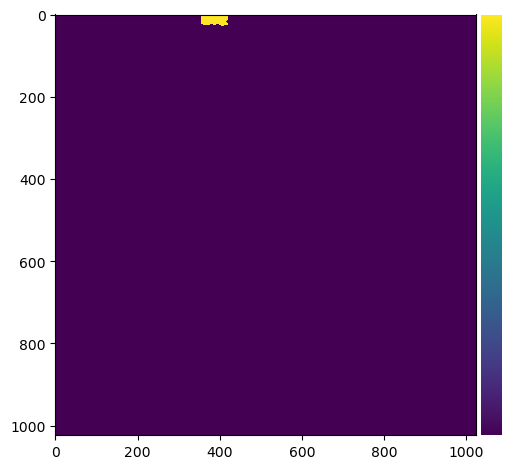

In [65]:
example = items_change[4]
show_img(example.mask)
ax = plt.gca()
ax.scatter(*example.meta[0]["point_coords"][0], color='green', marker='*', s=20)
ax.scatter(*example.meta[1][0]["point_coords"][0], color='green', marker='*', s=20)

bbox1 = example.meta[0]["bbox"]
bbox1 = ((bbox1[:2]), *bbox1[2:])

bbox2 = example.meta[1][0]["bbox"]
bbox2 = ((bbox2[:2]), *bbox2[2:])

colors = plt.cm.rainbow(np.linspace(0, 1, len(boxes)))
ax.add_patch(Rectangle(*bbox1,
             edgecolor = colors[np.random.choice(colors.shape[0], size=1)],
             fill=False,
             lw=2))

ax.add_patch(Rectangle(*bbox2,
             edgecolor = colors[np.random.choice(colors.shape[0], size=1)],
             fill=False,
             lw=2))

* meta is the same through items changes

In [29]:
from segment_any_change.utils import flatten
boxes = [_.meta for _ in items_change if isinstance(_.meta, list)]
boxes = flatten(boxes)

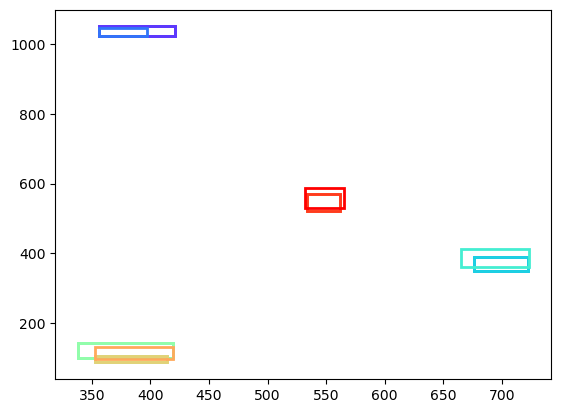

In [34]:
from matplotlib.patches import Rectangle

boxes = [_.meta for _ in items_change if isinstance(_.meta, list)]
boxes = [_["bbox"] for _ in list(flatten(boxes))]

boxes = [((_[0], 1024-_[1]), *_[2:]) for _ in boxes]

colors = plt.cm.rainbow(np.linspace(0, 1, len(boxes)))

fig, ax = plt.subplots()

#create simple line plot
ax.plot()from matplotlib.patches import Rectangle

for bbox,c in zip(boxes, colors):
    #add rectangle to plot
    ax.add_patch(Rectangle(*bbox,
                 edgecolor = c,
                 fill=False,
                 lw=2))

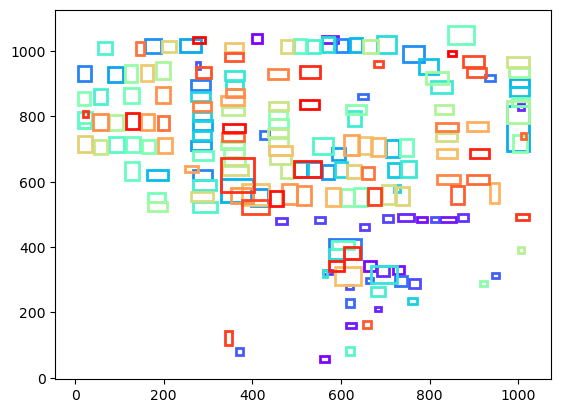

In [24]:
from matplotlib.patches import Rectangle

boxes = [_.meta["bbox"] for _ in items_change if isinstance(_.meta, dict)]
boxes = [((_[0], 1024-_[1]), *_[2:]) for _ in boxes]

colors = plt.cm.rainbow(np.linspace(0, 1, len(boxes)))

fig, ax = plt.subplots()

#create simple line plot
ax.plot()
for bbox,c in zip(boxes, colors):
    #add rectangle to plot
    ax.add_patch(Rectangle(*bbox,
                 edgecolor = c,
                 fill=False,
                 lw=2))

In [47]:
input_points

array([[[272., 272.]]])

In [48]:
input_points[0][0]

array([272., 272.])

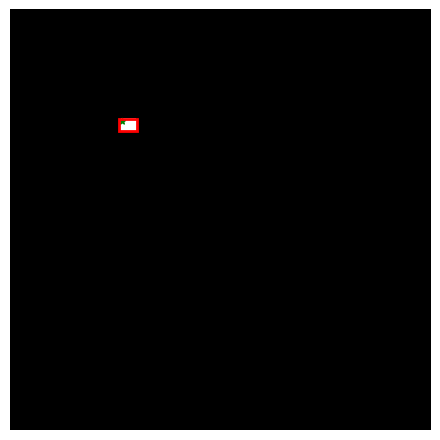

In [49]:
show_img(items_change[idx].mask)
ax = plt.gca()
ax.scatter(*input_points[0][0], color='green', marker='*', s=20)

bbox = items_change[idx].meta["bbox"]
bbox = ((bbox[:2]), *bbox[2:])

colors = plt.cm.rainbow(np.linspace(0, 1, len(boxes)))
ax.add_patch(Rectangle(*bbox,
             edgecolor = colors[np.random.choice(colors.shape[0], size=1)],
             fill=False,
             lw=2))


In [51]:
len(sim_obj_change)

191

/home/MDizier/miniforge3/envs/magic_pen/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


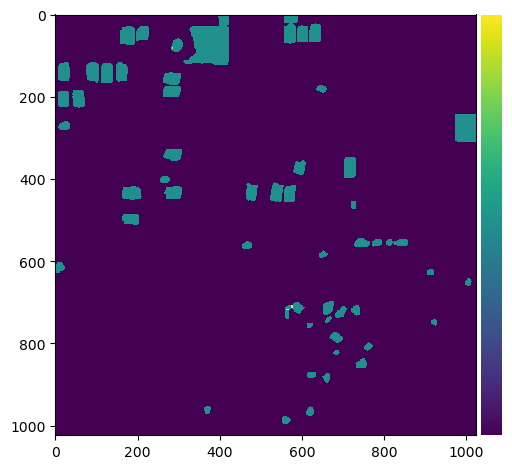

In [42]:
show_img(np.sum(np.stack([_.mask for _ in sim_obj_change]), axis=0))

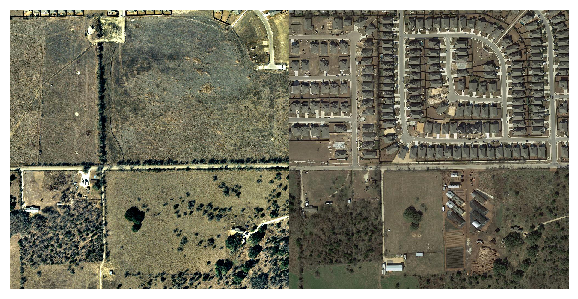

In [43]:
show_pair_img(img_A, img_B)

#### Output SegAnyChange - deprecated return see src

In [9]:
masks_emb_t_mA = res["mask_embedding"]["t->t+1"][0]
masks_emb_t1_mA = res["mask_embedding"]["t->t+1"][1]

masks_emb_t_mB = res["mask_embedding"]["t+1->t"][0]
masks_emb_t1_mB = res["mask_embedding"]["t+1->t"][1]

In [10]:
img_emb_A = res["A"]["img_embedding"]
img_emb_B = res["B"]["img_embedding"]

In [11]:
mask_Af = res["A"]["global_mask"]
mask_Bf = res["B"]["global_mask"]

ci = res["conf"]["t->t+1"]
ci1 = res["conf"]["t+1->t"]

In [13]:
mask_A = segany.get_mask_proposal(ImgType.A)
mask_B = segany.get_mask_proposal(ImgType.B)

### Exploration modules Any Change

In [ ]:
print(np.linalg.norm(img_emb_A))
print(np.linalg.norm(img_emb_B))


In [ ]:
print(np.linalg.norm(masks_emb_t_mA[0]))
print(np.linalg.norm(masks_emb_t1_mA[0]))


In [ ]:
print(np.linalg.norm(masks_emb_t_mB[34]))
print(np.linalg.norm(masks_emb_t1_mB[34]))

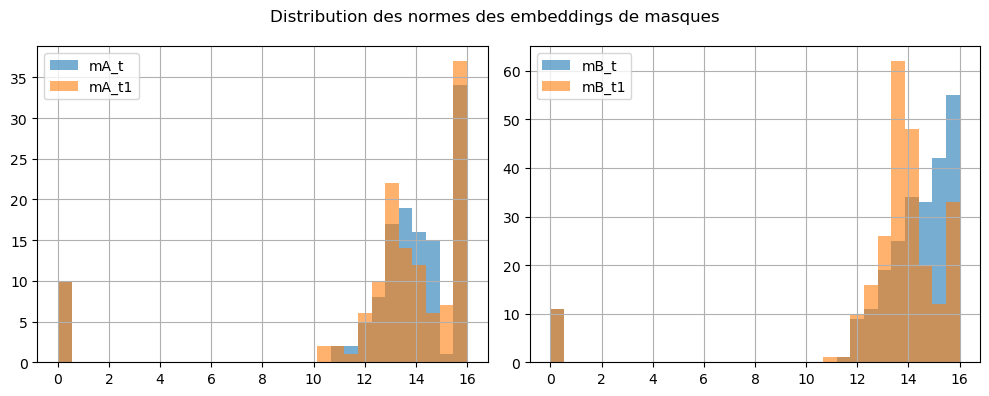

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))

pd.Series([np.linalg.norm(_) for _ in masks_emb_t_mA]).hist(ax=axes[0], label="mA_t", alpha=0.6, bins=30)
pd.Series([np.linalg.norm(_) for _ in masks_emb_t1_mA]).hist(ax=axes[0], label="mA_t1", alpha=0.6, bins=30)
axes[0].legend()

pd.Series([np.linalg.norm(_) for _ in masks_emb_t_mB]).hist(ax=axes[1], label="mB_t", alpha=0.6, bins=30)
pd.Series([np.linalg.norm(_) for _ in masks_emb_t1_mB]).hist(ax=axes[1], label="mB_t1", alpha=0.6, bins=30)
axes[1].legend()

fig.suptitle("Distribution des normes des embeddings de masques")
plt.tight_layout()

* Investiguer vectur norm null
* shift mB_t1

In [19]:
np.sqrt(256)

16.0

### Visualisation des masques

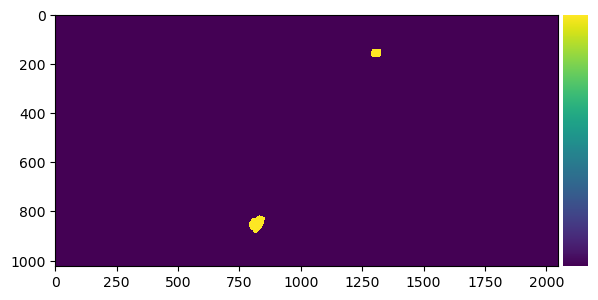

In [21]:
show_pair_img(mask_A[12], mask_B[12])

* Il faut un mapping spatial entre les masques A et B

* ci calculé via mask_A
* ciA calculé via mask_B

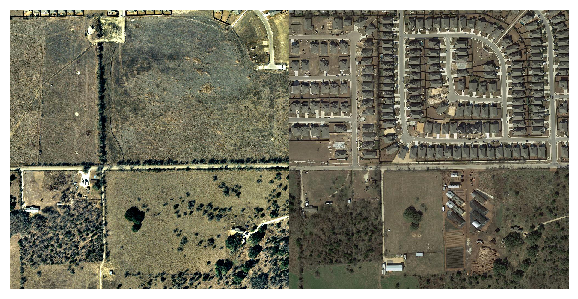

In [22]:
show_pair_img(img_A, img_B)

In [23]:
stack_mA = np.stack(mask_A)
stack_mB = np.stack(mask_B)

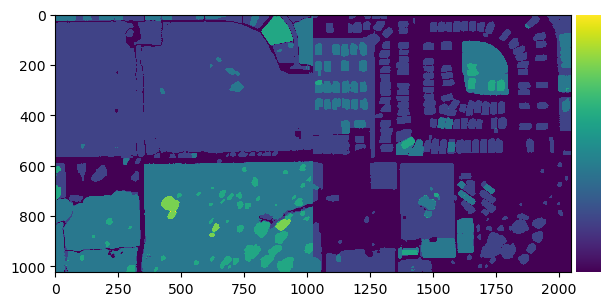

In [24]:
show_pair_img(
    np.sum(stack_mA, axis=0), 
    np.sum(stack_mB, axis=0)
)

### Fusion

##### Méthode 1 : individuals union (concat)
* Change proposal == 1 masque
* Filtrer les masques couvrant une même zone dans un second temps
* Pb :
    * 1 masque == 1 confidence score 
    * Pas vraiment de matching "bitemporal" => si via la similarité
 
      
##### Methode 2 : union geometry
* change proposal : union of mask on same area (same area to be define as a threshold)
* Pb :
    * Define threshold of Iou for Union
        * Union or selection of masks (min objets)
     
##### Methode 3 : individuals with union of score
* Change proposal == 1 masque
* Union (avg) des scores de confiance sur la zone
* Filtrer les masques couvrant une même zone dans un second temps

##### Methode 4 : concat and union of join masque
* join (union) geometry of same object mask (based on th IoU)
* otherwise consider 1 mask == 1 change proposal

Peut t on aggreger les ci avec les ci1 ? => pas les mêmes masks mais potentiellement les mêmes objets

* definition : 
    * zone de changement : définie une zone inter images

> The real-world change is defined at the same geographic location from time t to t + 1. This means that it is comparable only if two mask embeddings cover the approximate same geographic region

In [14]:
def rad_to_degre(x):
    return x*180/np.pi

def to_degre(x):
    return rad_to_degre(np.arccos(-x))

#### Methode 4

In [15]:
# identifcation of join areas
"""
join area == inter area == 0.8 of Union Area
"""

'\njoin area == inter area == 0.8 of Union Area\n'

In [16]:
from enum import Enum
class ImgType(Enum):
    A=1
    B=2

In [19]:
l = [1, 2, 3]
l.pop(0)

1

In [21]:
l.remove(2)

In [22]:
l

[3]

In [47]:
import itertools
from dataclasses import dataclass, field
from typing import List, Optional, Any, Dict, Optional



@dataclass
class ItemProposal:
    mask: np.ndarray
    confidence_score: float
    id: int = field(default_factory=itertools.count().__next__, init=False) # check how it works
    meta: List[Dict]
    chgt_angle: float = None
    from_img: List[ImgType]=None

    def __post_init__(self):
        if self.chgt_angle is None:
            self.chgt_angle = to_degre(self.confidence_score)
        
@dataclass
class ListProposal:
    items: Optional[List[ItemProposal]] = None
    index: int = 0

    def __post_init__(self) -> None:
        if self.items is None:
            self.items = []

    def add_item(self, item) -> None:
        if item.id not in [_.id for _ in self.items]:
            self.items.append(item)

    def rm_item(self, id: int) -> None:
        self.items = [_ for _ in self.items if _.id != id]

    def __getitem__(self, idx) -> ItemProposal:
        return self.items[idx]
    
    def __len__(self) -> int:
        return len(self.items)

        
def cover_same_zone(mask_A, mask_B, th=0.6) -> bool:
    inter_area = np.sum(np.logical_and(mask_A, mask_B))
    union_area = np.sum(np.logical_or(mask_A, mask_B))
    return inter_area > (union_area * th)

def create_union_object(item_A: ItemProposal, item_B: ItemProposal) -> ItemProposal:
    # filter on sim before merge ?
    return ItemProposal(mask=np.logical_or(item_A.mask, item_B.mask).astype(np.uint8), 
                        confidence_score=np.mean([item_A.confidence_score, item_B.confidence_score]), 
                        meta=[item_A.meta] + [item_B.meta], 
                        chgt_angle=np.mean([item_A.chgt_angle, item_B.chgt_angle]), 
                        from_img=[item_A.from_img, item_B.from_img])

print(f"nan values ci {np.sum(np.isnan(ci))}")
print(f"nan values ci1 {np.sum(np.isnan(ci1))}")

# nan value to be review

items_A = create_change_proposal_items(mask_Af, ci, ImgType.A)
items_B = create_change_proposal_items(mask_Bf, ci1, ImgType.B)


nan values ci 10
nan values ci1 11


In [32]:
mask_Af[0]

{'segmentation': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'area': 301105,
 'bbox': [340, 29, 683, 531],
 'predicted_iou': 1.0162211656570435,
 'point_coords': [[720.0, 112.0]],
 'stability_score': 0.9520628452301025,
 'crop_box': [0, 0, 1024, 1024]}

In [33]:
%%time
#deprecated"
filter_items = ListProposal()
track_id_union = set()
overlap = []

# speed-up items filtering on intersection - prevent futur large cartesian product
# to be improved
is_inter = lambda x,y: np.sum(np.logical_and(x, y)) > 1
for (it_A, it_B) in itertools.product(items_A, items_B):
    if is_inter(it_A.mask, it_B.mask):
        overlap.append((it_A, it_B))
        
# compute union on overlap pairs
for (it_A, it_B) in overlap:
    if cover_same_zone(it_A.mask, it_B.mask):
        filter_items.add_item(create_union_object(it_A, it_B))
        track_id_union.add(it_A.id)
        track_id_union.add(it_B.id)

# other union could be possible on existing union
#

# add masks A if not exists
for it_A in items_A:
    if it_A.id not in track_id_union:
        filter_items.add_item(it_A)

# add masks B if not exists
for it_B in items_B:
    if it_B.id not in track_id_union:
        filter_items.add_item(it_B)

CPU times: user 15 s, sys: 29.3 ms, total: 15.1 s
Wall time: 15.1 s


In [18]:
len(filter_items)

335

In [75]:
%%time
#deprecated
import multiprocessing as mp
filter_items = ListProposal()
track_id_union = set()
overlap = []

# speed-up items filtering on intersection - prevent futur large cartesian product
def is_inter(x,y):
    return np.sum(np.logical_and(x, y)) > 1

mask_A,mask_B = [_.mask for _ in items_A],[_.mask for _ in items_B]

with mp.Pool(processes=50) as pool:
    prod = list(itertools.product(mask_A, mask_B))
    results = pool.starmap(is_inter, prod)

CPU times: user 8.48 s, sys: 14.3 s, total: 22.8 s
Wall time: 30.4 s


### Fusion iterative des masques

In [48]:
%%time

filter_items = ListProposal()
track_id_union = set()
overlap = []

f_items = items_A + items_B

for insert_item in f_items:
    inserted = False
    for ref_item in filter_items:
        if cover_same_zone(insert_item.mask, ref_item.mask):
            filter_items.add_item(create_union_object(insert_item, ref_item))
            filter_items.rm_item(ref_item.id)
            inserted = True
    if not inserted:
        filter_items.add_item(insert_item)

CPU times: user 54.9 s, sys: 70.8 ms, total: 55 s
Wall time: 55 s


In [49]:
len(filter_items)

320

In [54]:
all_mask = [_.mask for _ in filter_items]
all_ci = [_.confidence_score for _ in filter_items]

sample_mask = [_.mask for _ in filter_items[:10]]
sample_ci = [_.confidence_score for _ in filter_items[:10]]

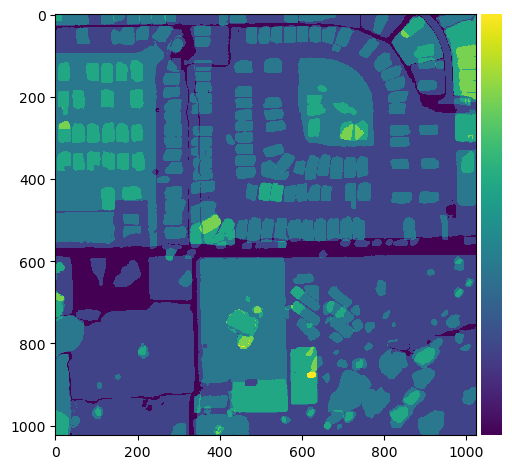

In [52]:
show_img(np.sum((np.stack(all_mask)), axis=0))

<Axes: >

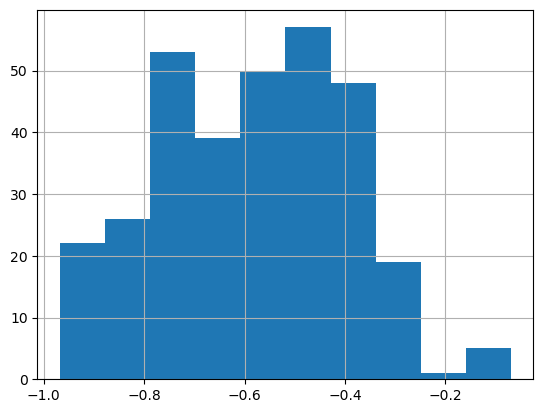

In [58]:
pd.Series(all_ci).hist()

In [25]:
np.quantile(all_ci, 0.25)

-0.7402088465530932

In [56]:
angle_chgt = [to_degre(_) for _ in all_ci]

<Axes: >

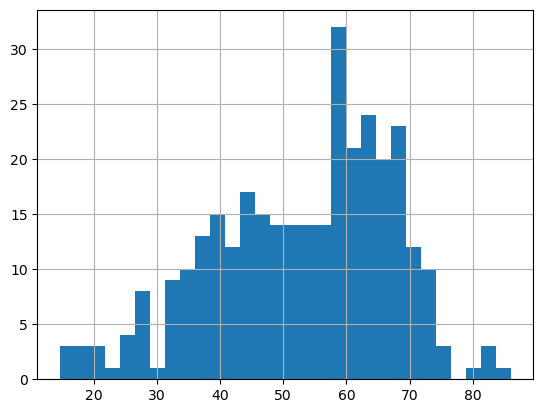

In [57]:
pd.Series(angle_chgt).hist(bins=30)

In [59]:
from skimage.filters import threshold_otsu

In [60]:
threshold_otsu(np.array(angle_chgt))

50.48126123142784

In [61]:
np.round(48.89, -1)

50.0

### Quantile thresholding <a name="seganychangeq"></a>

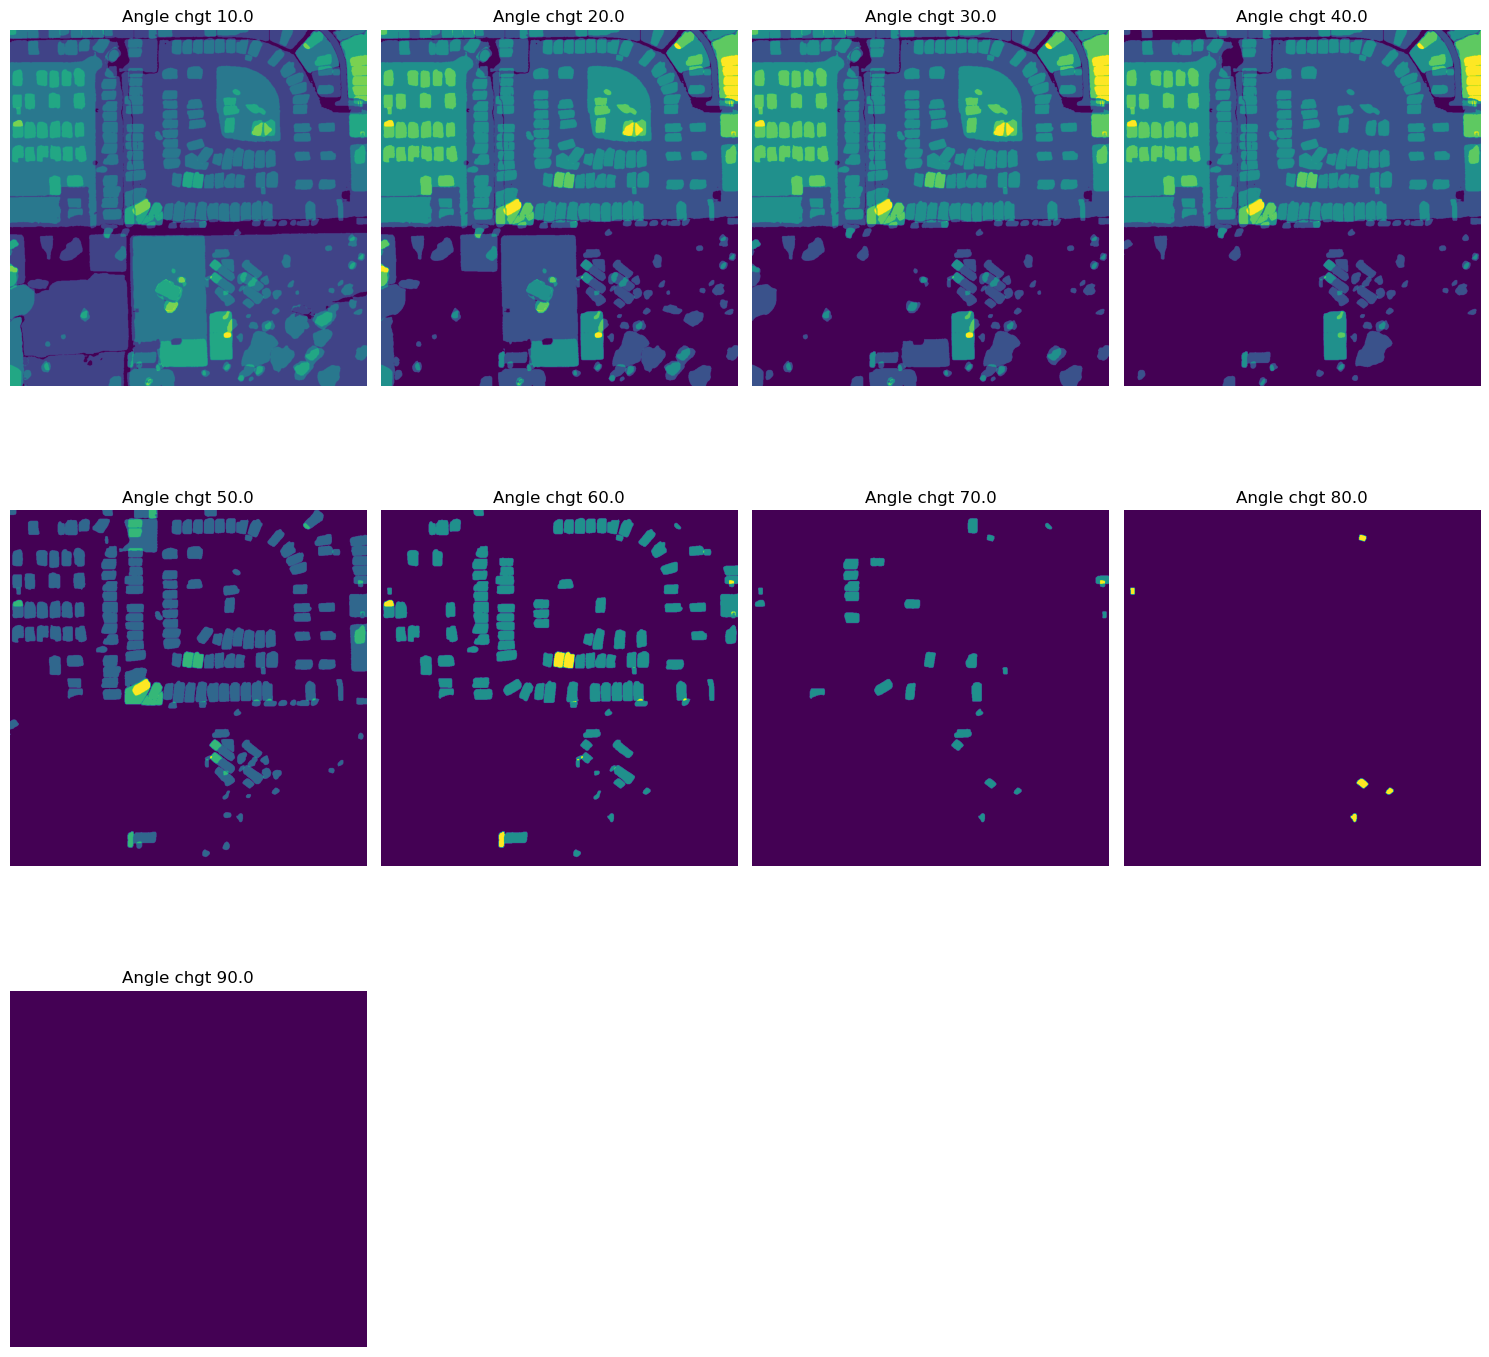

In [62]:
fig, axes = plt.subplots(3, 4, figsize=(15, 15))
axes = axes.ravel()

angle_th = sorted(set([np.round(_.chgt_angle, -1) for _ in filter_items]))

_ = [axes[_].set_visible(False) for _ in [9, 10, 11]]

for i, a in enumerate(angle_th):
    mask_stack = np.zeros((1024, 1024))
    q_mask = [_.mask for _ in filter_items if _.chgt_angle >= a]
    if q_mask:
        mask_stack = np.sum((np.stack(q_mask)), axis=0)
    axes[i].imshow(mask_stack)
    axes[i].set_axis_off()
    axes[i].set_title(f"Angle chgt {a:.1f}")
    
plt.tight_layout()

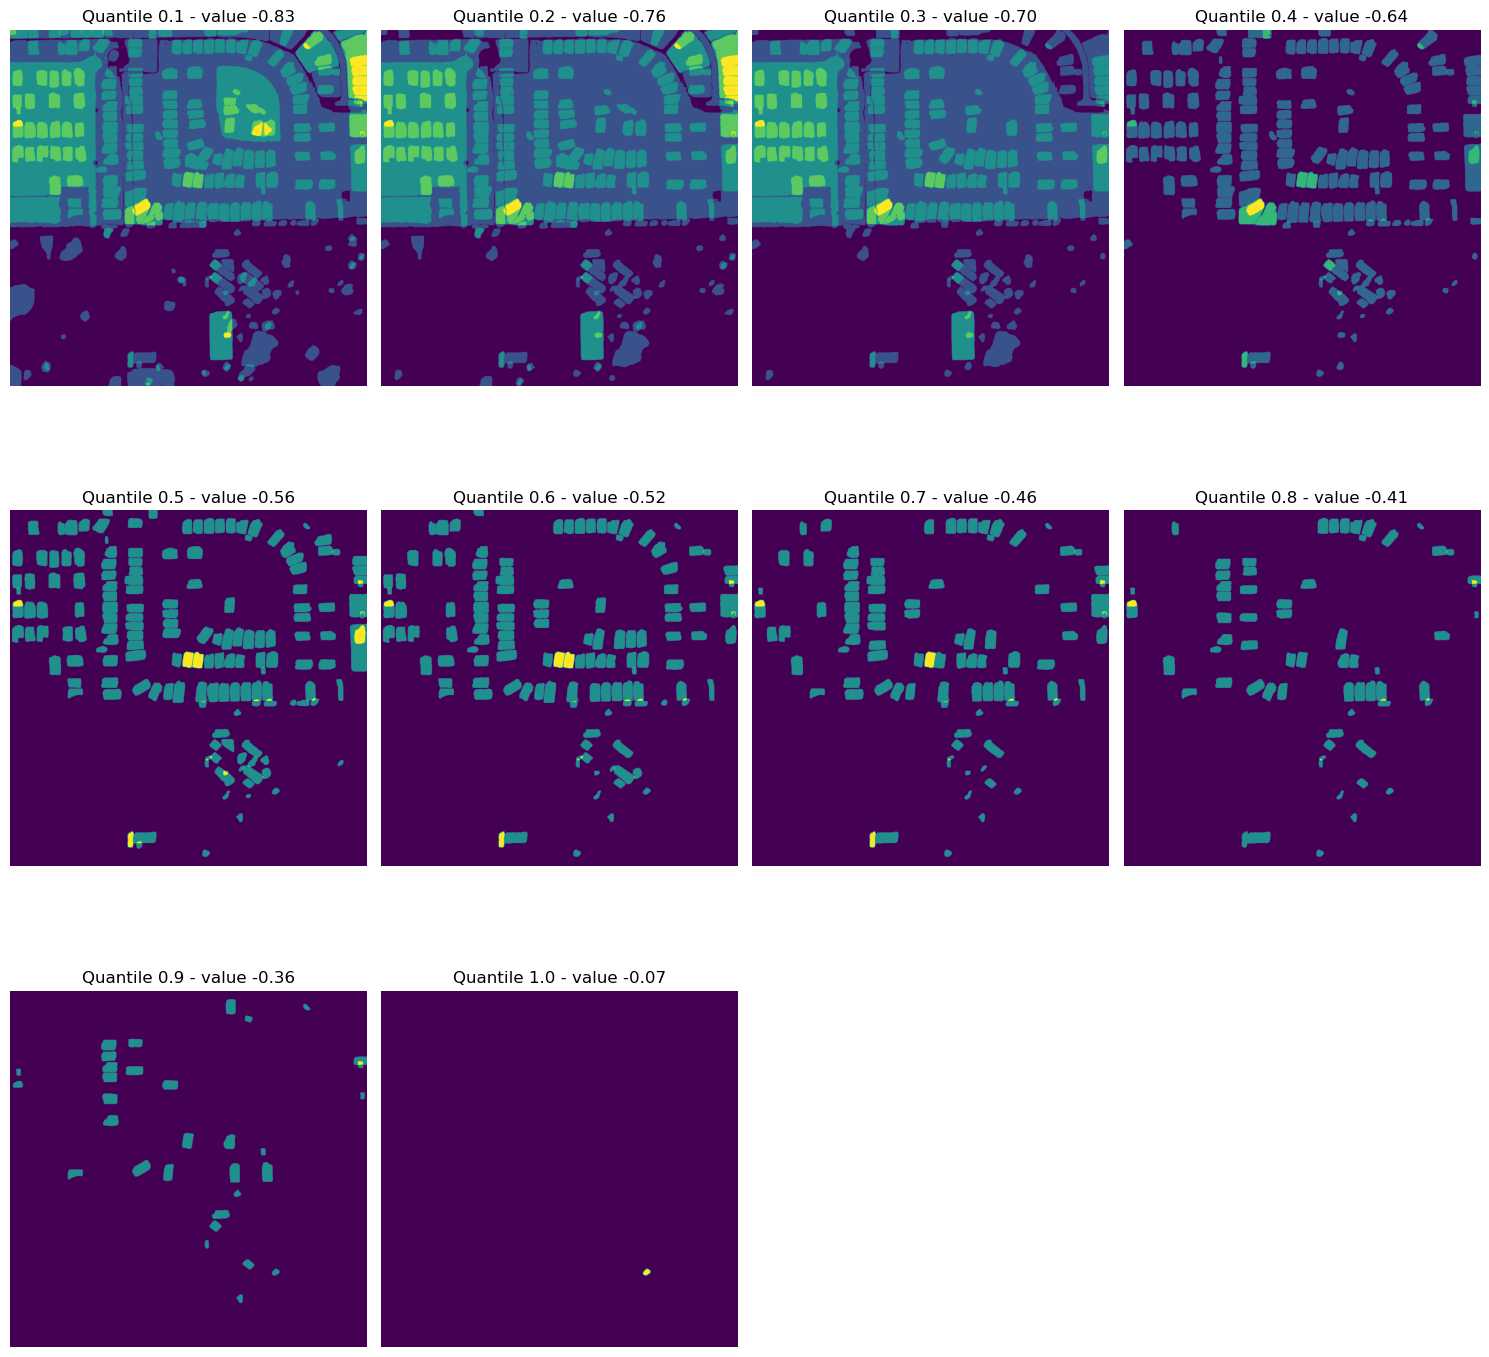

In [63]:
fig, axes = plt.subplots(3, 4, figsize=(15, 15))
axes = axes.ravel()
_ = [axes[_].set_visible(False) for _ in [10, 11]]

for i, q in enumerate(np.linspace(0.1, 1, 10)):
    mask_stack = np.zeros((1024, 1024))
    v = np.quantile([_.confidence_score for _ in filter_items], q)
    q_mask = [_.mask for _ in filter_items if _.confidence_score >= v]
    if q_mask:
        mask_stack = np.sum((np.stack(q_mask)), axis=0)
    axes[i].imshow(mask_stack)
    axes[i].set_axis_off()
    axes[i].set_title(f"Quantile {q:.1f} - value {v:.2f}")
    
plt.tight_layout()

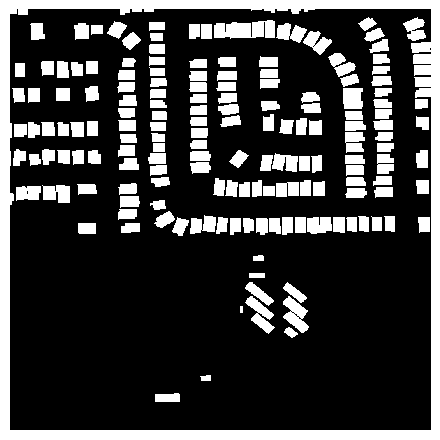

In [39]:
label = load_img(path_label)
show_img(label)

### Clustering changes